# Film Plot Generator
### Kwame V. Taylor

This project aims to generate a movie plot description based on seed input, such as director and genre. Data scraped from Wikipedia and found on Kaggle.

## Set up environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
import nltk
#nltk.download()

import unicodedata
import re
import json

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

from preprocessing import plots_split
import prepare

# default viz size settings
plt.rc('figure', figsize=(9, 7))
plt.rc('font', size=15)

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/a666/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# show nltk methods
dir(nltk)

['AbstractLazySequence',
 'AffixTagger',
 'AlignedSent',
 'Alignment',
 'AnnotationTask',
 'ApplicationExpression',
 'Assignment',
 'BigramAssocMeasures',
 'BigramCollocationFinder',
 'BigramTagger',
 'BinaryMaxentFeatureEncoding',
 'BlanklineTokenizer',
 'BllipParser',
 'BottomUpChartParser',
 'BottomUpLeftCornerChartParser',
 'BottomUpProbabilisticChartParser',
 'Boxer',
 'BrillTagger',
 'BrillTaggerTrainer',
 'CFG',
 'CRFTagger',
 'CfgReadingCommand',
 'ChartParser',
 'ChunkParserI',
 'ChunkScore',
 'Cistem',
 'ClassifierBasedPOSTagger',
 'ClassifierBasedTagger',
 'ClassifierI',
 'ConcordanceIndex',
 'ConditionalExponentialClassifier',
 'ConditionalFreqDist',
 'ConditionalProbDist',
 'ConditionalProbDistI',
 'ConfusionMatrix',
 'ContextIndex',
 'ContextTagger',
 'ContingencyMeasures',
 'CoreNLPDependencyParser',
 'CoreNLPParser',
 'Counter',
 'CrossValidationProbDist',
 'DRS',
 'DecisionTreeClassifier',
 'DefaultTagger',
 'DependencyEvaluator',
 'DependencyGrammar',
 'DependencyGrap

In [4]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

## Acquire data

In [5]:
df = pd.read_csv('plots.csv')
df.head(10)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
5,1903,Alice in Wonderland,American,Cecil Hepworth,May Clark,unknown,https://en.wikipedia.org/wiki/Alice_in_Wonderl...,"Alice follows a large white rabbit down a ""Rab..."
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,American,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....


## Narrow project scope

To narrow the project's scope, I'm going to focus on just American cinema.

In [6]:
df = df[df['Origin/Ethnicity'] == 'American']
df = df.drop(columns=['Origin/Ethnicity'])

## Summarize the data

In [7]:
# summarize data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17377 entries, 0 to 17376
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Release Year  17377 non-null  int64 
 1   Title         17377 non-null  object
 2   Director      17377 non-null  object
 3   Cast          17060 non-null  object
 4   Genre         17377 non-null  object
 5   Wiki Page     17377 non-null  object
 6   Plot          17377 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb7a2c05b0>]],
      dtype=object)

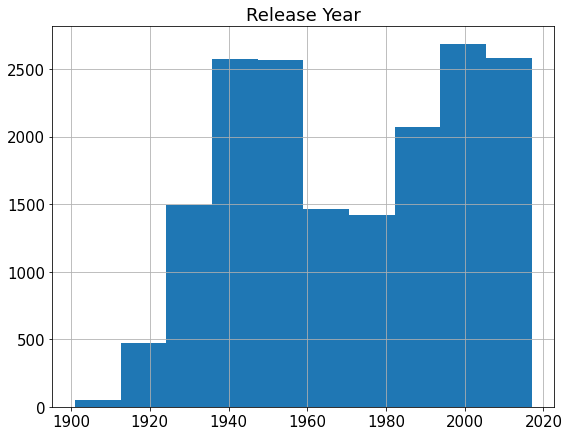

In [8]:
df.hist()

## Prepare the data

In [9]:
# check for nulls
df.isna().sum()

Release Year      0
Title             0
Director          0
Cast            317
Genre             0
Wiki Page         0
Plot              0
dtype: int64

In [10]:
df[df.isna().any(axis=1)]

,Release Year,Title,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...
6,1903,The Great Train Robbery,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
8,1905,The Little Train Robbery,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Little_Train...,The opening scene shows the interior of the ro...
9,1905,The Night Before Christmas,Edwin Stanton Porter,NaN,unknown,https://en.wikipedia.org/wiki/The_Night_Before...,Scenes are introduced using lines of the poem....
10,1906,Dream of a Rarebit Fiend,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...


I don't see too many noteable films here so I might drop rows with NaN for now. I'll marinate some thoughts on how I eventually want to handle all of the NaNs and 'Unknown's.

In [11]:
# drop NaNs
df = df.dropna()

In [12]:
# drop duplicates
df = df.drop_duplicates()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb71963730>]],
      dtype=object)

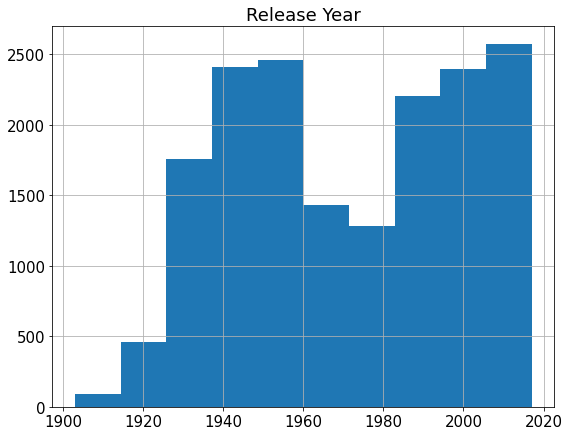

In [13]:
# check distribution of cont. variable(s) again
df.hist()

In [14]:
# fix for error
# "ValueError: The least populated class in y has only 1 member,
# which is too few. The minimum number of groups for any class
# cannot be less than 2."

df['Release Year'].value_counts()

df = df.drop(df[df['Release Year'] < 1904].index)
df['Release Year'].value_counts()

2006    326
2013    313
1996    287
1951    266
1997    261
2012    259
2007    259
1940    255
1957    252
1941    249
1950    247
1956    243
1995    240
1953    238
1939    236
1942    234
1944    230
1952    222
1988    222
1994    221
1955    220
1943    219
1948    219
1987    215
1989    215
1998    214
1990    214
2017    213
1949    212
1946    212
2009    208
2002    204
2005    204
2004    203
1945    203
1958    203
2001    202
1932    199
2003    199
1954    198
1947    197
1934    195
1935    195
1999    193
2010    192
1931    191
2000    190
2014    188
2008    187
2011    182
1933    181
1991    177
1993    177
1992    177
1930    175
1937    170
1985    166
1986    162
1959    155
1938    154
1936    146
1984    145
1971    131
1982    129
1964    127
1980    126
1961    125
2016    125
1929    124
1960    123
1968    123
1972    122
1962    120
1981    120
1973    120
1966    118
1963    118
2015    117
1977    116
1983    115
1978    114
1979    114
1967    113
1970

In [15]:
# clean, lemmetize, tokenize
df = prepare.prep_data(df, 'Plot')
df

,level_0,index,Release Year,Title,Director,Cast,Genre,Wiki Page,Plot,clean,stemmed,lemmatized,words,doc_length,stopwords_removed
0,0,13,1907,Daniel Boone,Wallace McCutcheon and Ediwin S. Porter,"William Craven, Florence Lawrence",biographical,https://en.wikipedia.org/wiki/Daniel_Boone_(19...,Boone's daughter befriends an Indian maiden as...,boone daughter befriends indian maiden boone c...,boone' daughter befriend an indian maiden as b...,boone's daughter befriends an indian maiden a ...,"[boone, daughter, befriends, indian, maiden, b...",67,53
1,1,14,1907,How Brown Saw the Baseball Game,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,heading baseball game nearby ballpark sport fa...,befor head out to a basebal game at a nearbi b...,before heading out to a baseball game at a nea...,"[heading, baseball, game, nearby, ballpark, sp...",54,49
2,2,15,1907,Laughing Gas,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,plot black woman going dentist toothache given...,the plot is that of a black woman go to the de...,the plot is that of a black woman going to the...,"[plot, black, woman, going, dentist, toothache...",23,25
3,3,16,1908,The Adventures of Dollie,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,beautiful summer day father mother take daught...,on a beauti summer day a father and mother tak...,on a beautiful summer day a father and mother ...,"[beautiful, summer, day, father, mother, take,...",73,70
4,4,17,1908,The Black Viper,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,thug accosts girl leaf workplace man rescue th...,a thug accost a girl as she leav her workplac ...,a thug accosts a girl a she leaf her workplace...,"[thug, accosts, girl, leaf, workplace, man, re...",49,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17054,17054,17372,2017,Crooked House,Gilles Paquet-Brenner,Gilles Paquet-Brenner (director/screenplay); T...,"crime, drama, mystery",https://en.wikipedia.org/wiki/Crooked_House_(f...,The granddaughter of late business tycoon Aris...,granddaughter late business tycoon aristide le...,the granddaught of late busi tycoon aristid le...,the granddaughter of late business tycoon aris...,"[granddaughter, late, business, tycoon, aristi...",572,476
17055,17055,17373,2017,Hostiles,Scott Cooper,Scott Cooper (director/screenplay); Donald E. ...,western,https://en.wikipedia.org/wiki/Hostiles_(film),"In 1892, settler Wesley Quaid and his family a...",1892 settler wesley quaid family attacked coma...,in 1892 settler wesley quaid and hi famili are...,in 1892 settler wesley quaid and his family ar...,"[1892, settler, wesley, quaid, family, attacke...",381,289
17056,17056,17374,2017,All the Money in the World,Ridley Scott,Ridley Scott (director); David Scarpa (screenp...,"biography, crime, drama",https://en.wikipedia.org/wiki/All_the_Money_in...,"In 1973, 16-year-old John Paul Getty III (Paul...",1973 16 year old john paul getty iii paul gran...,in 1973 16 year old john paul getti iii paul g...,in 1973 16 year old john paul getty iii paul g...,"[1973, 16, year, old, john, paul, getty, iii, ...",378,297
17057,17057,17375,2017,Molly's Game,Aaron Sorkin,Aaron Sorkin (director/screenplay); Jessica Ch...,"biography, crime, drama",https://en.wikipedia.org/wiki/Molly%27s_Game,Molly Bloom is world-class mogul skier with Ol...,molly bloom world class mogul skier olympic as...,molli bloom is world class mogul skier with ol...,molly bloom is world class mogul skier with ol...,"[molly, bloom, world, class, mogul, skier, oly...",446,330


In [16]:
# split the data
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = plots_split(df, 'Plot')
train.head(3)

Shape of train: (11940, 14) | Shape of validate: (2560, 14) | Shape of test: (2559, 14)
Percent train: 70.0        | Percent validate: 15.0       | Percent test: 15.0


,level_0,index,Release Year,Title,Director,Cast,Genre,Wiki Page,Plot,clean,stemmed,lemmatized,words,doc_length,stopwords_removed
14928,14928,15234,2007,Hostel: Part II,Eli Roth,"Lauren German, Roger Bart, Bijou Phillips, Hea...",horror,https://en.wikipedia.org/wiki/Hostel:_Part_II,"Shortly after the events of Hostel, Paxton is ...",shortly event hostel paxton suffering nightmar...,shortli after the event of hostel paxton is su...,shortly after the event of hostel paxton is su...,"[shortly, event, hostel, paxton, suffering, ni...",451,373
1133,1133,1154,1931,Little Caesar,Mervyn LeRoy,"Edward G. Robinson, Douglas Fairbanks, Jr., Gl...","drama, crime",https://en.wikipedia.org/wiki/Little_Caesar_(f...,"Small-time criminals Caesar Enrico ""Rico"" Band...",small time criminal caesar enrico rico bandell...,small time crimin caesar enrico rico bandello ...,small time criminal caesar enrico rico bandell...,"[small, time, criminal, caesar, enrico, rico, ...",222,151
11306,11306,11528,1990,Spirit of '76,Lucas Reiner,"Carl Reiner, Rob Reiner",comedy,https://en.wikipedia.org/wiki/Spirit_of_%2776_...,"By the year 2176, a magnetic storm has degauss...",year 2176 magnetic storm degaussed recorded hi...,by the year 2176 a magnet storm ha degauss all...,by the year 2176 a magnetic storm ha degaussed...,"[year, 2176, magnetic, storm, degaussed, recor...",144,77


## Exploratory data analysis

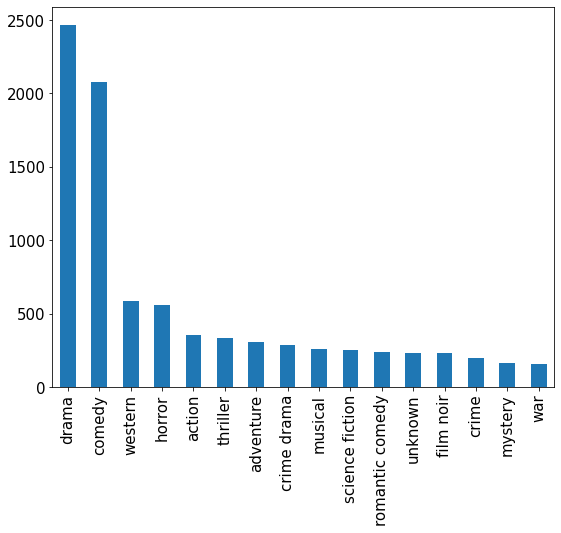

In [17]:
train['Genre'].value_counts().head(16).plot.bar()

In [18]:
#romance = 
train[train['Genre'] == 'romance']

,level_0,index,Release Year,Title,Director,Cast,Genre,Wiki Page,Plot,clean,stemmed,lemmatized,words,doc_length,stopwords_removed
13326,13326,13630,2000,Chocolat,Lasse Hallström,"Juliette Binoche, Judi Dench, Alfred Molina, L...",romance,https://en.wikipedia.org/wiki/Chocolat_(2000_f...,An unnamed female storyteller narrates the sto...,unnamed female storyteller narrates story vian...,an unnam femal storytel narrat the stori of vi...,an unnamed female storyteller narrates the sto...,"[unnamed, female, storyteller, narrates, story...",528,438
9256,9256,9413,1977,Roseland,James Ivory,"Teresa Wright, Geraldine Chaplin, Christopher ...",romance,https://en.wikipedia.org/wiki/Roseland_(film),"At Roseland, an older lady, May (Wright), with...",roseland older lady may wright light step look...,at roseland an older ladi may wright with a li...,at roseland an older lady may wright with a li...,"[roseland, older, lady, may, wright, light, st...",76,48
11674,11674,11910,1992,That Night,Craig Bolotin,"C. Thomas Howell, Juliette Lewis, Eliza Dushku",romance,https://en.wikipedia.org/wiki/That_Night,"In 1961 Long Island, Alice Bloom (Eliza Dushku...",1961 long island alice bloom eliza dushku ten ...,in 1961 long island alic bloom eliza dushku is...,in 1961 long island alice bloom eliza dushku i...,"[1961, long, island, alice, bloom, eliza, dush...",651,646
3775,3775,3834,1944,Johnny Doesn't Live Here Anymore,Joe May,"Simone Simon, James Ellison",romance,https://en.wikipedia.org/wiki/Johnny_Doesn%27t...,A young defense worker Kathie Aumont (Simone S...,young defense worker kathie aumont simone simo...,a young defens worker kathi aumont simon simon...,a young defense worker kathie aumont simone si...,"[young, defense, worker, kathie, aumont, simon...",141,113
14214,14214,14519,2004,P.S.,Dylan Kidd,"Laura Linney, Topher Grace, Gabriel Byrne",romance,https://en.wikipedia.org/wiki/P.S._(film),Thirty-nine-year old divorcée Louise Harringto...,thirty nine year old divorcee louise harringto...,thirti nine year old divorce louis harrington ...,thirty nine year old divorcee louise harringto...,"[thirty, nine, year, old, divorcee, louise, ha...",102,73
13512,13512,13816,2001,Captain Corelli's Mandolin,John Madden,"Nicolas Cage, Penélope Cruz",romance,https://en.wikipedia.org/wiki/Captain_Corelli%...,Greece's Ionian Islands are invaded by the Ita...,greece ionian island invaded italian army brin...,greece' ionian island are invad by the italian...,greece's ionian island are invaded by the ital...,"[greece, ionian, island, invaded, italian, arm...",244,208
13976,13976,14281,2003,The Human Stain,Robert Benton,"Anthony Hopkins, Nicole Kidman",romance,https://en.wikipedia.org/wiki/The_Human_Stain_...,"In the late 1990s, writer Nathan Zuckerman (Ga...",late 1990s writer nathan zuckerman gary sinise...,in the late 1990 writer nathan zuckerman gari ...,in the late 1990s writer nathan zuckerman gary...,"[late, 1990s, writer, nathan, zuckerman, gary,...",113,82
9959,9959,10120,1983,"Reuben, Reuben",Robert Ellis Miller,"Tom Conti, Kelly McGillis",romance,"https://en.wikipedia.org/wiki/Reuben,_Reuben",Gowan McGland (Tom Conti) is a creatively bloc...,gowan mcgland tom conti creatively blocked sco...,gowan mcgland tom conti is a creativ block sco...,gowan mcgland tom conti is a creatively blocke...,"[gowan, mcgland, tom, conti, creatively, block...",199,134
1345,1345,1367,1932,No More Orchids,Walter Lang,"Carole Lombard, Lyle Talbot",romance,https://en.wikipedia.org/wiki/No_More_Orchids,The departure of an ocean liner is held up to ...,departure ocean liner held wait spoiled heires...,the departur of an ocean liner is held up to w...,the departure of an ocean liner is held up to ...,"[departure, ocean, liner, held, wait, spoiled,...",155,141
3768,3768,3827,1944,"In the Meantime, Darling",Otto Preminger,Jeanne Crain,romance,"https://en.wikipedia.org/wiki/In_the_Meantime,...","Due to limited wartime housing, Army lieutenan...",due limited wartime housing army lieutenan

In [19]:
train['Genre'].value_counts()

drama                                                     2468
comedy                                                    2081
western                                                    590
horror                                                     558
action                                                     353
thriller                                                   336
adventure                                                  305
crime drama                                                284
musical                                                    262
science fiction                                            251
romantic comedy                                            239
unknown                                                    235
film noir                                                  234
crime                                                      197
mystery                                                    167
war                                                    

In [20]:
# create series objects for each of the top 17 genres that is a string of words joined on spaces to make it 1 continious string  
# in a later iteration, I will combine some of the similar genres
drama_words = ' '.join(train[train.Genre=='drama'].clean)
comedy_words = ' '.join(train[train.Genre=='comedy'].clean)
western_words = ' '.join(train[train.Genre=='western'].clean)
horror_words = ' '.join(train[train.Genre=='horror'].clean)
action_words = ' '.join(train[train.Genre=='action'].clean)
thriller_words = ' '.join(train[train.Genre=='thriller'].clean)
adventure_words = ' '.join(train[train.Genre=='adventure'].clean)
crime_drama_words = ' '.join(train[train.Genre=='crime drama'].clean)
musical_words = ' '.join(train[train.Genre=='musical'].clean)
science_fiction_words = ' '.join(train[train.Genre=='science fiction'].clean)
romantic_comedy_words = ' '.join(train[train.Genre=='romantic comedy '].clean)
film_noir_words = ' '.join(train[train.Genre=='film noir'].clean)
crime_words = ' '.join(train[train.Genre=='crime'].clean)
mystery_words = ' '.join(train[train.Genre=='mystery'].clean)
war_words = ' '.join(train[train.Genre=='war'].clean)
animation_words = ' '.join(train[train.Genre=='animation'].clean)
romance_words = ' '.join(train[train.Genre=='romance'].clean)
all_words = ' '.join(train.clean)

In [21]:
# Create a dataframe from all words single combined string
all_words_df = pd.DataFrame(all_words.split())

# Identify the top ten most frequently used words
all_words_df.value_counts().head(10)

find      11750
one       11059
go        10401
take      10084
get        9892
tell       9389
back       9195
new        8009
two        7951
father     7210
dtype: int64

In [22]:
romance_words

"unnamed female storyteller narrates story vianne rocher juliette binoche expert chocolatier drift across europe daughter anouk victoire thivisol following north wind beginning lenten season 1959 fifteen year war travel quiet french village closely adheres tradition dominated village mayor comte de reynaud alfred molina villager begin observing forty day lent vianne open chocolate shop much reynaud displeasure vianne wear colorful clothing village woman atheist illegitimate child fit well townspeople nevertheless optimistic business friendly alluring nature begin win villager one one causing reynaud openly speak tempting people time abstinence self denial comte admit wife left romantically interested caroline pursue one first fall spell vianne confection armande judi dench elderly eccentric landlady armande unhappy cold devoutly pious daughter caroline carrie anne moss let armande see grandson luc caroline think armande bad influence lost husband caroline overly protective luc even wan

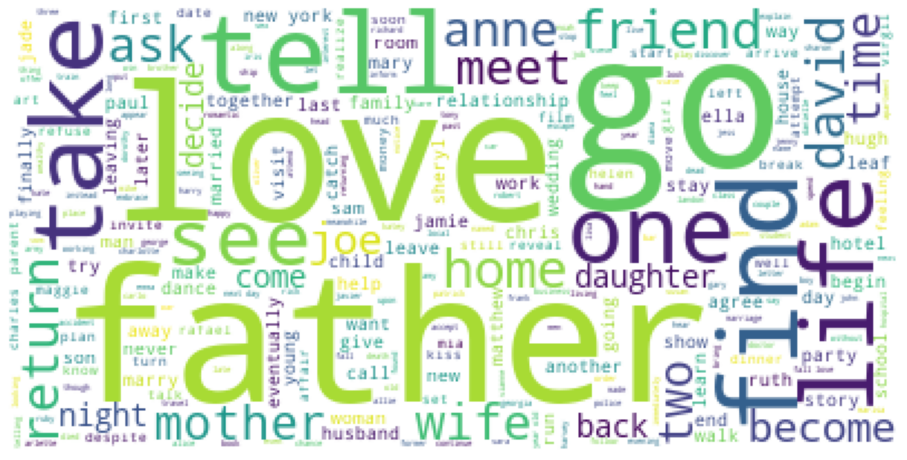

In [30]:
wordcloud = WordCloud(background_color="white", max_words=1000).generate(romance_words)
plt.rcParams['figure.figsize'] = 16, 22
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

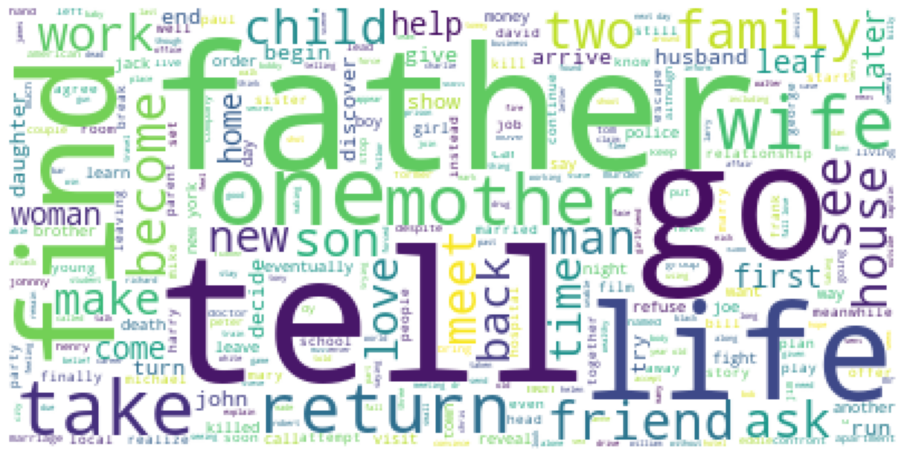

In [31]:
wordcloud = WordCloud(background_color="white", max_words=1000).generate(drama_words)
plt.rcParams['figure.figsize'] = 16, 22
plt.imshow(wordcloud)
plt.axis("off")
plt.show()